
# Import 使用到的套件


In [1]:
import numpy as np
from keras.layers import concatenate,Input, Dense, GaussianNoise,Lambda,Dropout,Activation,Conv1D,Reshape,multiply,Merge
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

from numpy.random import seed
from tensorflow import set_random_seed
from keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


# 宣告模擬的參數

In [2]:
M = 16
N = 7
ISI_TAPS=3
EQUALIZE_TAPS = 3
TRAINING_Esdb = 10

N_TRAIN=1000000
N_VAL=1000000
N_TEST=10000000

EPOCHS=30
BATCH=10000
PATIENCE=1000
SAVE= False
SAVE_PATH ='./lab5best.h5'

Esdb_TEST = np.arange(0,15,1)

# 宣告一般function

In [3]:
def cal_awgn_std(EsN0db):
    N0  = 1 / np.power(10,EsN0db/10)
    awgn_std = np.sqrt(N0)
    return awgn_std

def data_generator(N_TRAIN=100000,N_VAL=1000000,N_TEST=10000000,M=16):
    
    x_train   = np.arange(N_TRAIN)%M
    x_val     = np.random.randint(M,size=N_VAL)
    x_test    = np.random.randint(M,size=N_TEST)
    
    x_train   = to_categorical(x_train,M)
    x_val     = to_categorical(x_val,M)
    x_test    = to_categorical(x_test,M)
    np.random.shuffle(x_train)
    return x_train,x_val,x_test

def plot_result(Esdb,l_BLER=0,l_BER=0):
    if(l_BLER):
        plt.plot(Esdb , l_BLER , 'bo-', linewidth=1, alpha=0.6,label='Block error rate')
        plt.title('Block Error Rate vs Es/N0 ')
        plt.yscale('log')
        plt.xlabel('Es/N0')
        plt.ylabel('Block error rate')
        plt.grid()
        plt.legend(loc='lower left',ncol = 1)
        plt.show()
    if(l_BER):
        plt.plot(Esdb , l_BER , 'bo-', linewidth=1, alpha=0.6,label='Bit error rate')
        plt.title('Bit Error Rate vs Es/N0 ')
        plt.yscale('log')
        plt.xlabel('Es/N0')
        plt.ylabel('Bit error rate')
        plt.grid()
        plt.legend(loc='lower left',ncol = 1)
        plt.show()

# 宣告Model及用在Model上的function

In [4]:
awgn_std = cal_awgn_std(TRAINING_Esdb)

def ISI_Channel(x):
    taps = K.l2_normalize(tf.random_normal((ISI_TAPS,1,1),mean=0.0,stddev=1.0,dtype=tf.float32),axis=0)
#    taps = tf.constant(np.array([1,2,3]).reshape((3,1,1)), dtype=np.float32)
    return K.conv1d(x, taps, strides=1, padding='causal',data_format='channels_last')

def AWGN(x):
    noise = K.random_normal(shape=K.shape(x),mean=0.0,stddev=awgn_std)
    return x + noise

def equalize(x):
    taps = K.reshape(K.mean(x[1], axis=0),(EQUALIZE_TAPS,1,1))
    return K.conv1d(x[0], taps, strides=1, padding='causal',data_format='channels_last')

def code_normalization(x):
    return np.sqrt(K.int_shape(x)[1])*K.l2_normalize(x,axis=1)

def get_model(isi_taps=3,equalize_taps=3,m=16,n=7,verbose=1):
    input_signal = Input(shape=(m,))
    encoded1     = Dense(m,activation='relu',name='encoded1')(input_signal)
    encoded2     = Dense(n,activation='linear',name='encoded2')(encoded1)
    encoder_out  = Lambda(code_normalization,name='encoder_out')(encoded2)
    encoder_out  = Reshape((n,1),name='reshape_encoder_out7_1')(encoder_out)

    ISI_code     = Lambda(ISI_Channel,name='ISI_Channel')(encoder_out)
    ISI_code     = Reshape((1,n),name='reshape_ISI_code1_7')(ISI_code)

    AWGN_code1_7 = Lambda(AWGN,name='reshape_AWGN1_7') (ISI_code)
    AWGN_code7_1 = Reshape((n,1),name='reshape_AWGN7_1')(AWGN_code1_7)

    w_estimate1  = Dense(n,name='w_estimate1') (AWGN_code1_7)
    w_estimate2  = Dense(n,name='w_estimate2') (w_estimate1)
    w_estimate3  = Dense(equalize_taps,name='w_estimate3') (w_estimate2 )
    w_estimate3  = Reshape((1,equalize_taps),name='reshape_w_estimate3')(w_estimate3)
    equalize1    = Lambda(equalize, name='equalize1')([AWGN_code7_1,w_estimate3])
    equalize1    = Reshape((n,), name='reshape_equalize1')(equalize1)
    decoded1     = Dense(m,activation='relu',name='decoded1')(equalize1)
    decoded2     = Dense(m,activation='softmax',name='decoded2')(decoded1)

    autoencoder = Model(input_signal, decoded2)
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    if(verbose):
        autoencoder.summary()


    return autoencoder


def train_model(model,source,target,source_val,target_val,epochs=100, batch=1000,patience=1000,save=0,save_path ='./lab5best.h5'):
    if(SAVE):
        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)
        checkpointer   = ModelCheckpoint(SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min', period=1)
        hist = model.fit(source,target,validation_data=(source_val,target_val),epochs=epochs,batch_size=batch,callbacks=[checkpointer,early_stopping],shuffle=True)
        return model,hist
    
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)
        hist = model.fit(source,target,validation_data=(source_val,target_val),epochs=epochs,batch_size=batch,callbacks=[early_stopping],shuffle=True)
        return model,hist



# Main Function

In [5]:
x_train,x_val,x_test = data_generator(N_TRAIN,N_VAL,N_TEST,M)
autoencoder = get_model(ISI_TAPS,EQUALIZE_TAPS,M,N,verbose=1)
autoencoder,hist = train_model(autoencoder,x_train,x_train,x_val,x_val,EPOCHS,BATCH,PATIENCE,SAVE,SAVE_PATH)
autoencoder_weights = autoencoder.get_weights()

l_BLER = list()
for SNR in Esdb_TEST :
    def AWGN(x):
        noise = K.random_normal(shape=K.shape(x),mean=0.0,stddev=cal_awgn_std(SNR))
        return x + noise
    autoencoder = get_model(ISI_TAPS,EQUALIZE_TAPS,M,N,verbose=0)
    autoencoder.set_weights(autoencoder_weights)
    preds = autoencoder.predict(x_test,batch_size=BATCH,verbose=1)
    BLER = np.sum(np.argmax(preds,axis=1) != np.argmax(x_test,axis=1)) / N_TEST
    print('Es/N0:'+str(SNR)+'BLER:'+str(BLER))
    l_BLER.append(BLER)
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16)            0                                            
____________________________________________________________________________________________________
encoded1 (Dense)                 (None, 16)            272         input_1[0][0]                    
____________________________________________________________________________________________________
encoded2 (Dense)                 (None, 7)             119         encoded1[0][0]                   
____________________________________________________________________________________________________
encoder_out (Lambda)             (None, 7)             0           encoded2[0][0]                   
___________________________________________________________________________________________

10000000/10000000 [==============================] - 4s     
Es/N0:7BLER:0.0368444
10000000/10000000 [==============================] - 4s     
Es/N0:10BLER:0.003426
 9880000/10000000 [============================>.] - ETA: 0sEs/N0:14BLER:2.24e-05


c:\users\eason\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
c:\users\eason\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mathtext.py:855: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


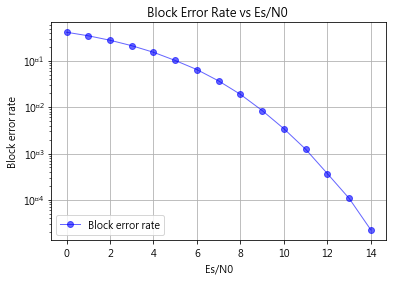

In [6]:
 plot_result(Esdb_TEST,l_BLER)